# Stochastic Optimal Control & Reinforcment Learning : Part VI

In [42]:
import numpy as np
import model
import lstd
import utils
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Prerequesite

We define a function to compute the value function of the LQR policy 

In [43]:
def ricatti_recursion(A, B, Q, R, S, P0, eps = 1e-6, max_iter = 1000):

    Pnew = P0
    Pold = P0
    for _ in range(max_iter):
        Pnew = Q + A.T @ Pold @ A - (A.T @ Pold @ B + S).T @ np.linalg.inv(R + B.T @ Pold @ B) @ (A.T @ Pold @ B + S)
        if np.linalg.norm(Pnew - Pold) < eps:
            print("Converged")
            break
        Pold = Pnew

    return Pnew

P = ricatti_recursion(model.A, model.B, model.Q, model.R, model.S, np.eye(5))

def V_functionLQR(x):
    return x.T @ P @ x


Converged


## 7. Mean Square Belman Error

### 2. Estimation of MSBE linear system

We implement the subroutine to compute the conditional expectation

In [44]:
def cond_expect(phi : callable, psi_Q : callable, next_states_probs : list) -> np.ndarray:
    """
    Computes the conditional expectation E_{x'} [psi_Q(x', phi(x')) | x, u]
    when the transition kernel has finite support.

    Parameters:
    - phi: Policy function, phi(x') returns action at state x'.
    - psi_Q: Function that computes the feature vector psi_Q(x', u').
    - next_states_probs: List of tuples (x'_i, p_i), where x'_i is a possible next state
                         and p_i is the probability of transitioning to x'_i from (x, u).

    Returns:
    - expectation: The computed conditional expectation as a feature vector.
    """

    expectation = 0
    for x_prime, p in next_states_probs:
        u_prime = phi(x_prime)
        psi_value = psi_Q(x_prime, u_prime)
        expectation += p * psi_value
    return expectation

In [45]:
def compute_next_states_probs(x : np.ndarray, u : np.ndarray, transition_kernel : list, model_str : str = "lin") -> list:
    """
    Computes the list of next states and their probabilities given the current state and action.
    
    Parameters:
    - x: The current state.
    - u: The current action.
    - transition_kernel: List of tuples (w_i, p_i) where w_i is the transition noise and p_i is the probability of transitioning to x + w_i.
    
    Returns:
    - next_states_probs: List of tuples (x'_i, p_i), where x'_i is a possible next state
                         and p_i is the probability of transitioning to x'_i from (x, u).
    """

    next_states_probs = []
    for w_i, p_i in transition_kernel:
        if model_str == "lin":
            x_prime = model.linear_step(x, u, w_i)
        elif model_str == "nonlin":
            x_prime = model.non_linear_step(x, u, w_i)
        else:
            raise ValueError("Invalid model type. Must be 'lin' or 'nonlin'.")

        next_states_probs.append((x_prime, p_i))
    
    return next_states_probs

and the function to compute the MSBE

In [46]:
def compute_MSBE(data, transition_kernel, psi_Q_func, psi_eta_vect, model_str = "lin", policy : callable = model.LQR_policy):
    """
    Computes the Mean-Squared Bellman Error (MSBE) for a given dataset and policy.

    Parameters:
    - data: List of tuples (x, u, r, x_prime).
    - transition_kernel: List of tuples (w_i, p_i) where w_i is the transition noise and p_i is the probability of transitioning to x + w_i.
    - psi_Q_func: Function that computes the feature vector psi_Q(x, u).
    - psi_eta_vect: Feature vector for the reward function.
    - model_str: String indicating the model type. Must be 'lin' or 'nonlin'.

    Returns:
    - MSBE: The computed MSBE.
    """

    n_step = len(data[1])
    theta_dim = len(psi_eta_vect)

    A = np.zeros((theta_dim, theta_dim))
    b = np.zeros(theta_dim)

    for x_i, u_i in zip(data[0].T, data[1].T):

        next_states_probs = compute_next_states_probs(x_i, u_i, transition_kernel, model_str=model_str)
        cond_expectation  = cond_expect(policy, psi_Q_func, next_states_probs)

        psi_Q_i = psi_Q_func(x_i, u_i)
        c_i = model.cost(x_i, u_i)

        f_i = cond_expectation - psi_Q_i - psi_eta_vect

        A += np.outer(f_i, f_i)
        b -= f_i * c_i

    A /= n_step
    b /= n_step

    A += np.eye(theta_dim) * 1e-6  # Regularization

    # Solve the linear system
    theta_MSBE = np.linalg.solve(A, b)
    return theta_MSBE


def policy_improvement_MSBE(initial_policy, psi_func, psi_eta_vect, transition_kernel, data, model_str = "lin", max_iter = 100):
    """
    Computes the policy improvement step using the MSBE objective.

    Parameters:
    - theta: The current parameter vector.
    - psi_Q_func: Function that computes the feature vector psi_Q(x, u).
    - psi_eta_vect: Feature vector for the reward function.
    - model_str: String indicating the model type. Must be 'lin' or 'nonlin'.

    Returns:
    - theta_new: The updated parameter vector.
    """

    theta_MSBE = None
    policy = initial_policy

    for iter in range(max_iter):
        theta_MSBE = compute_MSBE(data, transition_kernel, psi_func, psi_eta_vect, model_str=model_str, policy=policy)
        
        def improved_policy(x):
            res = minimize(lambda u : psi_func(x, u) @ theta_MSBE, 1)
            return res.x

        policy = improved_policy

    return theta_MSBE

### 3. Implementation of MSBE linear system

We define a function to generate a transition kernel with finite support

In [47]:
def generate_finite_kernel(n_noises: int, noise_std: float, k: int = 2) -> list:
    """
    Generates a finite transition kernel for a 2D Gaussian noise model.

    Parameters:
    - n_noises: Number of noise values per dimension (total will be n_noises^2).
    - noise_std: Standard deviation of the noise (same for both dimensions).
    - k: Defines the range of the noise as [-k * noise_std, k * noise_std].

    Returns:
    - transition_kernel: List of tuples (w_i, p_i) where w_i is the 2D noise vector,
      and p_i is the joint probability of transitioning to x + w_i.
    """
    # Define the range of noise values for each dimension
    x_min = -k * noise_std
    x_max = k * noise_std
    
    # Generate a grid of noise values for both dimensions
    noise_values_1d = np.linspace(x_min, x_max, n_noises, endpoint=True)
    grid_x, grid_y = np.meshgrid(noise_values_1d, noise_values_1d)
    noise_vectors = np.column_stack([grid_x.ravel(), grid_y.ravel()])  # Shape: (n_noises^2, 2)
    
    # Define the 2D Gaussian distribution
    mean = np.zeros(2)
    cov = np.diag([noise_std**2, noise_std**2])
    mvn = multivariate_normal(mean=mean, cov=cov)
    
    # Compute probabilities for each noise vector
    probabilities = mvn.pdf(noise_vectors)
    probabilities /= np.sum(probabilities)  # Normalize to sum to 1
    
    # Return the noise vectors and their probabilities
    return list(zip(noise_vectors, probabilities))

We know define the exploration policy which is a baseline policy perturbed by noise to explore

In [48]:
def phi_e(x : np.ndarray, exploration_std : float, baseline_policy : callable = model.LQR_policy) -> np.ndarray:

    """
    Generates an exploratory action using a Gaussian distribution with standard deviation exploration_std around a baseline policy.
    
    Parameters:
    - x: The state.
    - exploration_std: Standard deviation of the Gaussian distribution.
    - baseline_policy: The baseline policy function, baseline_policy(x) returns the action at state x.
    
    Returns:
    - u: The generated action.
    """
    exploration_noise = np.random.normal(0, exploration_std)
    u = baseline_policy(x) + exploration_noise

    return u

## a. Linear Model : Approximation of LQR Q-function

We define $\psi_Q$ and $\psi_\eta$

In [49]:
def psi_Q(x, u):

    if not np.isscalar(u):
        u = u[0]
        
    x1 = x[0]
    x4 = x[3]
    x5 = x[4]
    psi = [x1**2, x4**2, x5**2, u**2, x1*u, x4*u, x5*u,\
             x1*x4, x1*x5, x4*x5]

    return np.array(psi)

psi_eta = np.ones(10)

We first investigate the impact of the process noise 

In [50]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 100
exploration_std = 1e-2
M = 10 


n_noises = 20 # 20**2 combinations of noises
noises_std = [1e-4, 0.1, 0.5, 1, 2]
V_function_noises = {}

for noise_std in noises_std:

    V_lqr_train, V_lqr_test, V_msbe_train, V_msbe_test = [] , [] , [] , []

    for _ in range(M):
        # Simulate data

        policy_explo = lambda x: phi_e(x, exploration_std=exploration_std)
        data_train = model.simulate_linear_model(x0_train, policy_explo, n_step, with_noise=True, std_const=noise_std)
        data_lqr_test = model.simulate_linear_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const=noise_std)

        # Compute MSBE

        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
        theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="lin")
        Q_MSBE = lambda x, u : model.Q_function(x, u, theta = theta_MSBE, psi_func = psi_Q)

        V_lqr_train.append(np.array([V_functionLQR(x) for x in data_train[0][:, :-1].T]).squeeze())
        V_lqr_test.append(np.array([V_functionLQR(x) for x in data_lqr_test[0][:, :-1].T]).squeeze())

        V_msbe_train.append(np.array([Q_MSBE(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze())
        V_msbe_test.append(np.array([Q_MSBE(x, u) for x, u in zip(data_lqr_test[0].T, data_lqr_test[1].T)]).squeeze())



    V_function_noises[noise_std] = {
            "V_noise_train" : np.mean(V_lqr_train, axis = 0),
            "V_noise_test" : np.mean(V_lqr_test, axis = 0),
            "V_MSBE_train" : np.mean(V_msbe_train, axis = 0),
            "V_MSBE_test" : np.mean(V_msbe_test, axis = 0)
        }


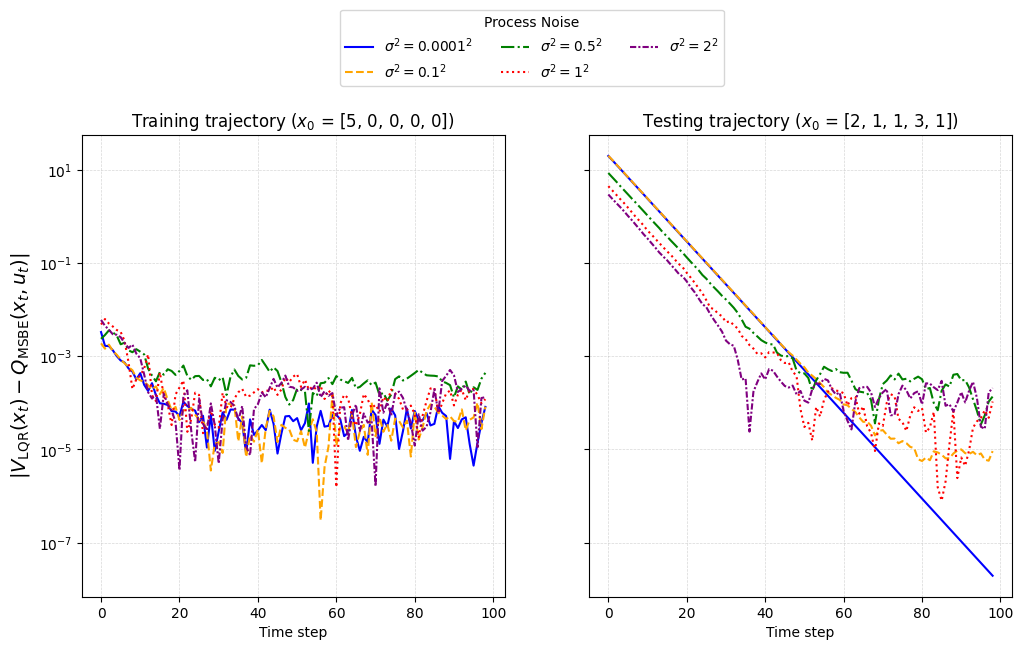

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for (noise_std, V_function_noise), linestyle, color in zip(V_function_noises.items(), linestyles, colors):
    ax1.semilogy(np.clip(np.abs(V_function_noise["V_noise_train"] - V_function_noise["V_MSBE_train"]), 1e-18, None), label=fr"$\sigma^2 = {noise_std}^2$", linestyle=linestyle, color=color)
    ax2.semilogy(np.clip(np.abs(V_function_noise["V_noise_test"] - V_function_noise["V_MSBE_test"]), 1e-18, None), label=f"$\sigma^2 = {noise_std}^2$", linestyle=linestyle, color=color)

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1), title = "Process Noise")

ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

ax2.set_title(rf"Testing trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

plt.show()



We now investigate the impact of the exploration policy std

In [52]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 100
M = 10

n_noises = 20 # 20**2 combinations of noises
noise_std = 0.1

V_function_explo = {}
noises_explo = [0.0, 1e-3, 0.1, 1.0, 2]

for noise_explo in noises_explo:
    V_lqr_train_vals, V_lqr_test_vals, V_msbe_train_vals, V_msbe_test_vals = [], [], [], []

    for _ in range(M):  # Perform M simulations

        # Simulate data
        data_lqr_test = model.simulate_linear_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const = noise_std)
        policy_explo = lambda x: phi_e(x, exploration_std=noise_explo)
        data_train = model.simulate_linear_model(x0_train, policy_explo, n_step, std_const = noise_std, with_noise=True)

        # Compute MSBE
        
        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=2)
        theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="lin")
        Q_MSBE = lambda x, u: model.Q_function(x, u, theta=theta_MSBE, psi_func=psi_Q)

        V_lqr_train = np.array([V_functionLQR(x) for x in data_train[0].T]).squeeze()
        V_lqr_test = np.array([V_functionLQR(x) for x in data_lqr_test[0].T]).squeeze()

        V_msbe_train = np.array([Q_MSBE(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze()
        V_msbe_test = np.array([Q_MSBE(x, u) for x, u in zip(data_lqr_test[0].T, data_lqr_test[1].T)]).squeeze()

        V_lqr_train_vals.append(V_lqr_train)
        V_lqr_test_vals.append(V_lqr_test)
        V_msbe_train_vals.append(V_msbe_train)
        V_msbe_test_vals.append(V_msbe_test)

    # Compute mean and std for each metric
    V_function_explo[noise_explo] = {
        "V_lqr_train_mean": np.mean(V_lqr_train_vals, axis=0),
        "V_lqr_test_mean": np.mean(V_lqr_test_vals, axis=0),
        "V_msbe_train_mean": np.mean(V_msbe_train_vals, axis=0),
        "V_msbe_test_mean": np.mean(V_msbe_test_vals, axis=0),
        
    }


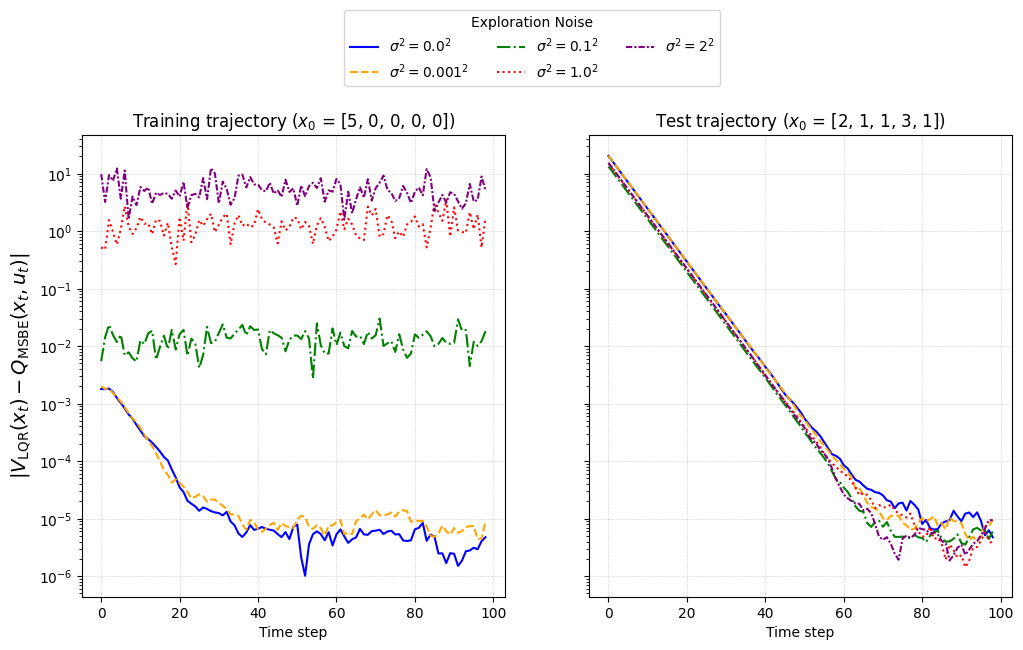

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for (noise_std, stats), linestyle, color in zip(V_function_explo.items(), linestyles, colors):
    train_error_mean = np.abs(stats["V_lqr_train_mean"][:-1] - stats["V_msbe_train_mean"])
    test_error_mean = np.abs(stats["V_lqr_test_mean"][:-1] - stats["V_msbe_test_mean"])


    time_steps = np.arange(len(train_error_mean))


    ax1.semilogy(
        np.clip(train_error_mean, 1e-18, None),
        label=fr"$\sigma^2 = {noise_std}^2$",
        linestyle=linestyle,
        color=color,
    )

    ax2.semilogy(
        np.clip(test_error_mean, 1e-18, None),
        label=fr"$\sigma^2 = {noise_std}^2$",
        linestyle=linestyle,
        color=color,
    )

# Add shared legend
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1), title="Exploration Noise")

# Customize the subplots
ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

ax2.set_title(rf"Test trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

plt.show()

## b. Non Linear Model : Approximation of the LQR Q-function

We define $\psi_Q$ and $\psi_\eta$

In [54]:
def psi_Q(x, u):

    if not np.isscalar(u):
        u = u[0]
        
    x1 = x[0]
    x4 = x[3]
    x5 = x[4]
    psi = [x1**2, x4**2, x5**2, u**2, x1*u, x4*u, x5*u,\
             x1*x4, x1*x5, x4*x5]

    return np.array(psi)

psi_eta = np.ones(10)

We first investigate the impact of the process noise 

In [55]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 100
exploration_std = 1e-2
M = 10 


n_noises = 20 # 20**2 combinations of noises
noises_std = [1e-4, 0.1, 0.5, 1, 2]
V_function_noises = {}

for noise_std in noises_std:

    V_lqr_train, V_lqr_test, V_msbe_train, V_msbe_test = [] , [] , [] , []

    for _ in range(M):
        # Simulate data

        policy_explo = lambda x: phi_e(x, exploration_std=exploration_std)
        data_train = model.simulate_nl_model(x0_train, policy_explo, n_step, with_noise=True, std_const=noise_std)
        data_lqr_test = model.simulate_nl_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const=noise_std)

        # Compute MSBE

        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=2)
        theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="lin")
        Q_MSBE = lambda x, u : model.Q_function(x, u, theta = theta_MSBE, psi_func = psi_Q)

        V_lqr_train.append(np.array([V_functionLQR(x) for x in data_train[0][:, :-1].T]).squeeze())
        V_lqr_test.append(np.array([V_functionLQR(x) for x in data_lqr_test[0][:, :-1].T]).squeeze())

        V_msbe_train.append(np.array([Q_MSBE(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze())
        V_msbe_test.append(np.array([Q_MSBE(x, u) for x, u in zip(data_lqr_test[0].T, data_lqr_test[1].T)]).squeeze())



    V_function_noises[noise_std] = {
            "V_noise_train" : np.mean(V_lqr_train, axis = 0),
            "V_noise_test" : np.mean(V_lqr_test, axis = 0),
            "V_MSBE_train" : np.mean(V_msbe_train, axis = 0),
            "V_MSBE_test" : np.mean(V_msbe_test, axis = 0)
        }

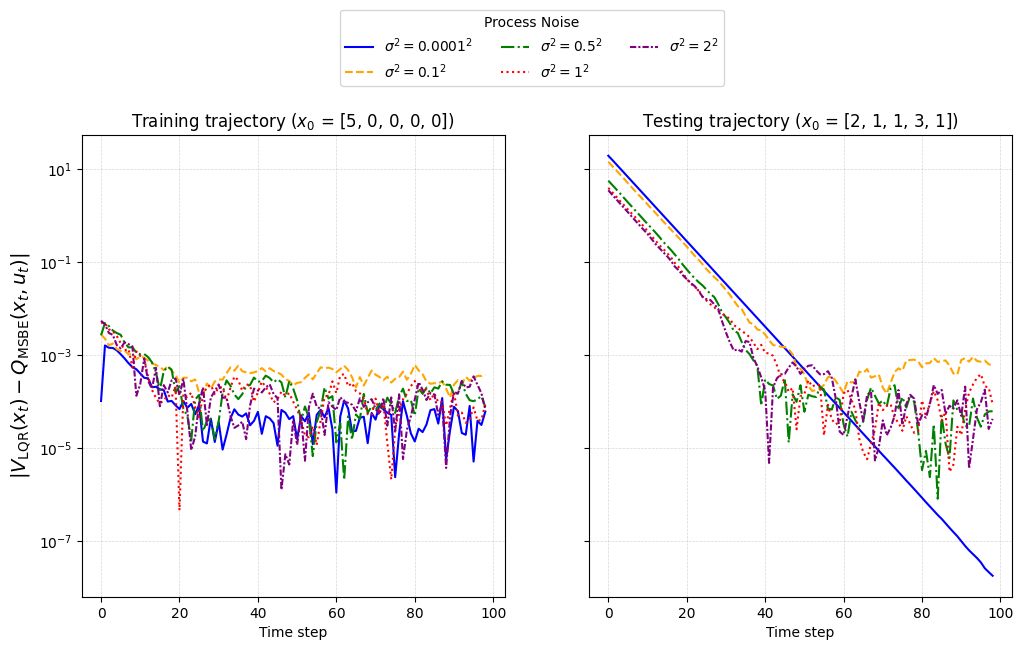

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for (noise_std, V_function_noise), linestyle, color in zip(V_function_noises.items(), linestyles, colors):
    ax1.semilogy(np.clip(np.abs(V_function_noise["V_noise_train"] - V_function_noise["V_MSBE_train"]), 1e-18, None), label=fr"$\sigma^2 = {noise_std}^2$", linestyle=linestyle, color=color)
    ax2.semilogy(np.clip(np.abs(V_function_noise["V_noise_test"] - V_function_noise["V_MSBE_test"]), 1e-18, None), label=f"$\sigma^2 = {noise_std}^2$", linestyle=linestyle, color=color)

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1), title = "Process Noise")

ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

ax2.set_title(rf"Testing trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

plt.show()

and we do the same for LSTD

In [57]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 100
exploration_std = 1e-2
M = 10 


n_noises = 20 # 20**2 combinations of noises
noises_std = [1e-4, 0.1, 0.5, 1, 2]
V_function_noises = {}

for noise_std in noises_std:

    V_lqr_train, V_lqr_test, V_msbe_train, V_msbe_test = [] , [] , [] , []

    for _ in range(M):
        # Simulate data

        policy_explo = lambda x: phi_e(x, exploration_std=exploration_std)
        data_train = model.simulate_nl_model(x0_train, policy_explo, n_step, with_noise=True, std_const=noise_std)
        data_lqr_test = model.simulate_nl_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const=noise_std)

        # Compute MSBE

        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
        theta_LSTD = lstd.perform_lstd(model.LQR_policy, model.cost, psi_Q, np.eye(10), data_train, d = 10)
        Q_LSTD = lambda x, u : model.Q_function(x, u, theta = theta_LSTD, psi_func = psi_Q)

        V_lqr_train.append(np.array([V_functionLQR(x) for x in data_train[0][:, :-1].T]).squeeze())
        V_lqr_test.append(np.array([V_functionLQR(x) for x in data_lqr_test[0][:, :-1].T]).squeeze())

        V_msbe_train.append(np.array([Q_LSTD(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze())
        V_msbe_test.append(np.array([Q_LSTD(x, u) for x, u in zip(data_lqr_test[0].T, data_lqr_test[1].T)]).squeeze())



    V_function_noises[noise_std] = {
            "V_noise_train" : np.mean(V_lqr_train, axis = 0),
            "V_noise_test" : np.mean(V_lqr_test, axis = 0),
            "V_MSBE_train" : np.mean(V_msbe_train, axis = 0),
            "V_MSBE_test" : np.mean(V_msbe_test, axis = 0)
        }

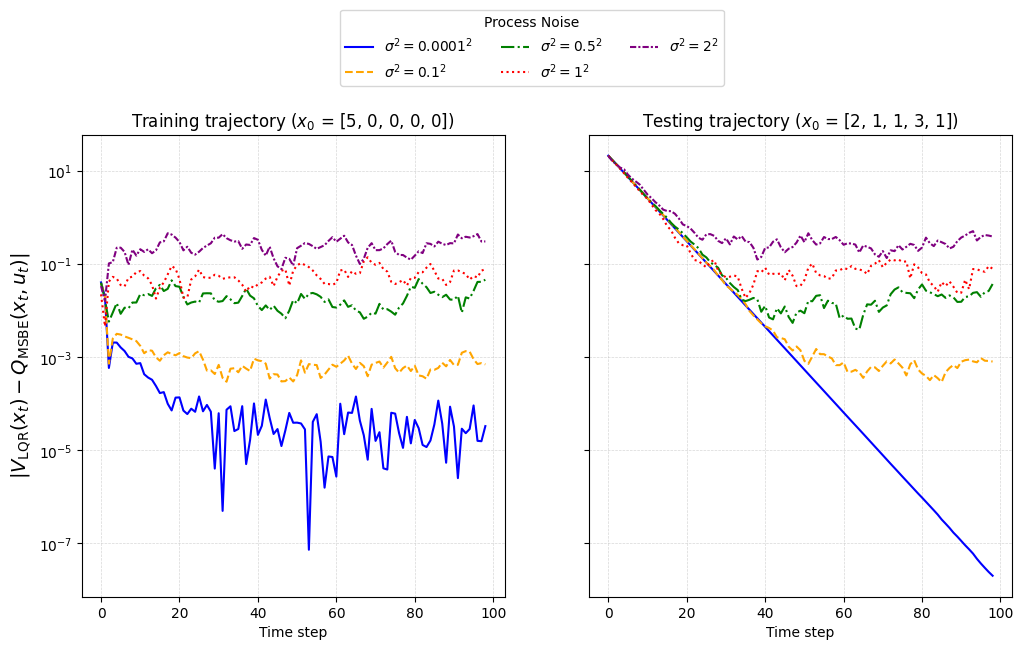

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for (noise_std, V_function_noise), linestyle, color in zip(V_function_noises.items(), linestyles, colors):
    ax1.semilogy(np.clip(np.abs(V_function_noise["V_noise_train"] - V_function_noise["V_MSBE_train"]), 1e-18, None), label=fr"$\sigma^2 = {noise_std}^2$", linestyle=linestyle, color=color)
    ax2.semilogy(np.clip(np.abs(V_function_noise["V_noise_test"] - V_function_noise["V_MSBE_test"]), 1e-18, None), label=f"$\sigma^2 = {noise_std}^2$", linestyle=linestyle, color=color)

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1), title = "Process Noise")

ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

ax2.set_title(rf"Testing trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

plt.show()

We now investigate the impact of the exploration policy only for MSBE 

In [59]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 100
M = 10

n_noises = 20 # 20**2 combinations of noises
noise_std = 0.1

V_function_explo = {}
noises_explo = [0.0, 1e-3, 0.1, 1.0, 2]

for noise_explo in noises_explo:
    V_lqr_train_vals, V_lqr_test_vals, V_msbe_train_vals, V_msbe_test_vals = [], [], [], []

    for _ in range(M):  # Perform M simulations

        # Simulate data
        data_lqr_test = model.simulate_nl_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const=noise_std)
        policy_explo = lambda x: phi_e(x, exploration_std=noise_explo)
        data_train = model.simulate_nl_model(x0_train, policy_explo, n_step, with_noise=True, std_const=noise_std)

        # Compute MSBE
        
        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
        theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="nonlin")
        Q_MSBE = lambda x, u: model.Q_function(x, u, theta=theta_MSBE, psi_func=psi_Q)

        V_lqr_train = np.array([V_functionLQR(x) for x in data_train[0].T]).squeeze()
        V_lqr_test = np.array([V_functionLQR(x) for x in data_lqr_test[0].T]).squeeze()

        V_msbe_train = np.array([Q_MSBE(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze()
        V_msbe_test = np.array([Q_MSBE(x, u) for x, u in zip(data_lqr_test[0].T, data_lqr_test[1].T)]).squeeze()

        V_lqr_train_vals.append(V_lqr_train)
        V_lqr_test_vals.append(V_lqr_test)
        V_msbe_train_vals.append(V_msbe_train)
        V_msbe_test_vals.append(V_msbe_test)

    # Compute mean and std for each metric
    V_function_explo[noise_explo] = {
        "V_lqr_train_mean": np.mean(V_lqr_train_vals, axis=0),
        "V_lqr_test_mean": np.mean(V_lqr_test_vals, axis=0),
        "V_msbe_train_mean": np.mean(V_msbe_train_vals, axis=0),
        "V_msbe_test_mean": np.mean(V_msbe_test_vals, axis=0),
        
    }


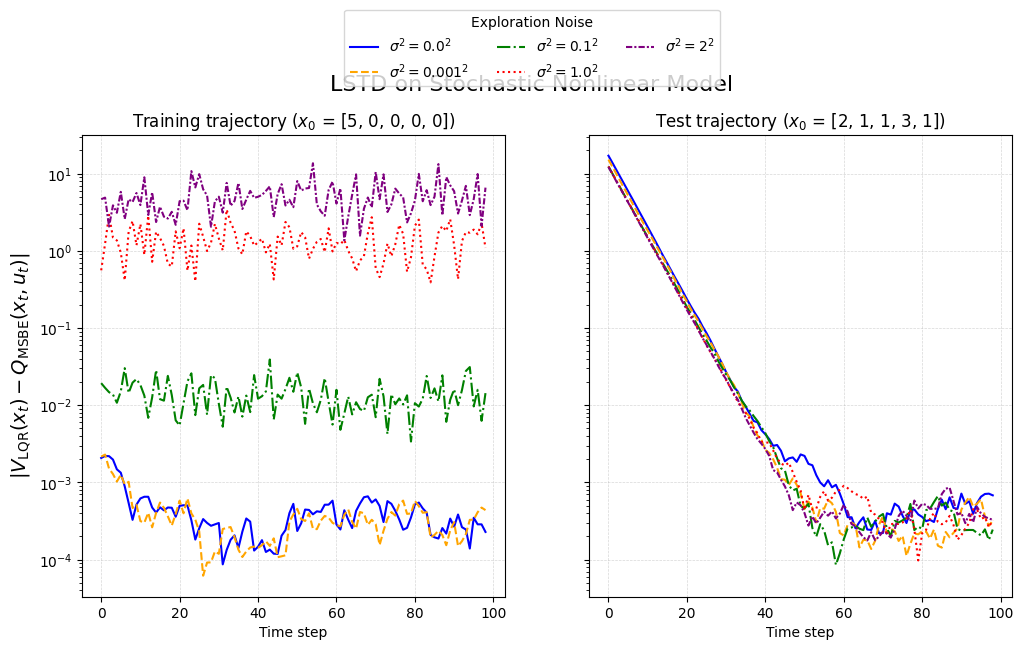

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for (noise_std, stats), linestyle, color in zip(V_function_explo.items(), linestyles, colors):
    train_error_mean = np.abs(stats["V_lqr_train_mean"][:-1] - stats["V_msbe_train_mean"])
    test_error_mean = np.abs(stats["V_lqr_test_mean"][:-1] - stats["V_msbe_test_mean"])


    time_steps = np.arange(len(train_error_mean))


    ax1.semilogy(
        np.clip(train_error_mean, 1e-18, None),
        label=fr"$\sigma^2 = {noise_std}^2$",
        linestyle=linestyle,
        color=color,
    )

    ax2.semilogy(
        np.clip(test_error_mean, 1e-18, None),
        label=fr"$\sigma^2 = {noise_std}^2$",
        linestyle=linestyle,
        color=color,
    )

# Add shared legend
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1), title="Exploration Noise")

# Customize the subplots
ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

ax2.set_title(rf"Test trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

# plt.suptitle("LSTD on Stochastic Nonlinear Model", fontsize=16)
plt.show()

### c. Policy Improvement 

#### Linear Model with another policy than LQR as inital policy

In [65]:
import tqdm
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 100
M = 10

n_noises = 20 # 20**2 combinations of noises
noise_std = 0.5
transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=2)

noise_explo = 0.1
policy_explo = lambda x: phi_e(x, exploration_std=noise_explo)

def init_policy(x):
    return np.zeros(1)


V_function_PI_train, V_function_PI_test, V_function_lqr_train, V_function_lqr_test = [], [], [], []

for _ in tqdm.tqdm(range(M)):

    data_train = model.simulate_linear_model(x0_train, policy_explo, n_step, with_noise=True, std_const=noise_std)
    data_test = model.simulate_linear_model(x0_test, model.LQR_policy, n_step, with_noise=True, std_const=noise_std)

    theta_MSBE = policy_improvement_MSBE(init_policy, psi_Q, psi_eta, transition_kernel, data_train, model_str="lin", max_iter=5)

    Q_MSBE = lambda x, u : model.Q_function(x, u, theta = theta_MSBE, psi_func = psi_Q)

    V_function_PI_train.append(np.array([Q_MSBE(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze())
    V_function_PI_test.append(np.array([Q_MSBE(x, u) for x, u in zip(data_test[0].T, data_test[1].T)]).squeeze())

    V_function_lqr_train.append(np.array([V_functionLQR(x) for x in data_train[0][:, :-1].T]).squeeze())
    V_function_lqr_test.append(np.array([V_functionLQR(x) for x in data_test[0][:, :-1].T]).squeeze())

V_function_lin_PI = {
    "V_PI_train" : np.mean(V_function_PI_train, axis = 0),
    "V_PI_test" : np.mean(V_function_PI_test, axis = 0),
    "V_lqr_train" : np.mean(V_function_lqr_train, axis = 0),
    "V_lqr_test" : np.mean(V_function_lqr_test, axis = 0)
}



100%|██████████| 10/10 [06:48<00:00, 40.85s/it]


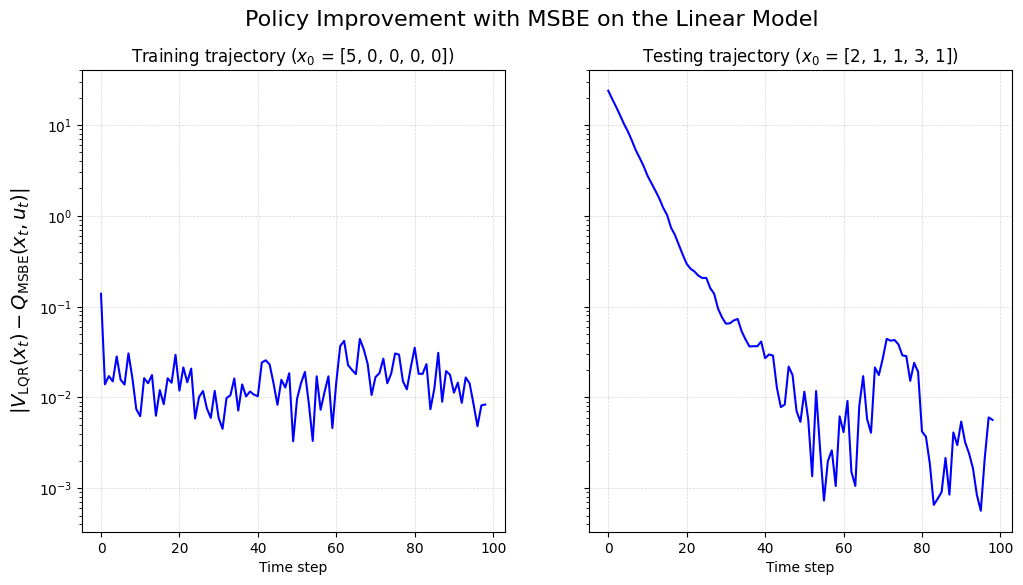

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']


ax1.semilogy(np.clip(np.abs(V_function_lin_PI["V_lqr_train"] - V_function_lin_PI["V_PI_train"]), 1e-18, None), color = 'blue')
ax2.semilogy(np.clip(np.abs(V_function_lin_PI["V_lqr_test"] - V_function_lin_PI["V_PI_test"]), 1e-18, None), color = 'blue')

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))

ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

ax2.set_title(rf"Testing trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

fig.suptitle("Policy Improvement with MSBE on the Linear Model", fontsize=16)
plt.show()

#### Non Linear Model with LQR as initial policy

In [75]:
import tqdm
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 100
M = 10

n_noises = 20 # 20**2 combinations of noises
noise_std = 0.5
transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=2)

noise_explo = 0.1
policy_explo = lambda x: phi_e(x, exploration_std=noise_explo)



V_function_PI_train, V_function_PI_test, V_function_lqr_train, V_function_lqr_test = [], [], [], []

for _ in tqdm.tqdm(range(M)):

    data_train = model.simulate_nl_model(x0_train, policy_explo, n_step, with_noise=True, std_const=noise_std)
    data_test = model.simulate_nl_model(x0_test, model.LQR_policy, n_step, with_noise=True, std_const=noise_std)

    theta_MSBE = policy_improvement_MSBE(model.LQR_policy, psi_Q, psi_eta, transition_kernel, data_train, model_str="nonlin", max_iter=5)

    Q_MSBE = lambda x, u : model.Q_function(x, u, theta = theta_MSBE, psi_func = psi_Q)

    V_function_PI_train.append(np.array([Q_MSBE(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze())
    V_function_PI_test.append(np.array([Q_MSBE(x, u) for x, u in zip(data_test[0].T, data_test[1].T)]).squeeze())

    V_function_lqr_train.append(np.array([V_functionLQR(x) for x in data_train[0][:, :-1].T]).squeeze())
    V_function_lqr_test.append(np.array([V_functionLQR(x) for x in data_test[0][:, :-1].T]).squeeze())

V_function_nonlin_PI = {
    "V_PI_train" : np.mean(V_function_PI_train, axis = 0),
    "V_PI_test" : np.mean(V_function_PI_test, axis = 0),
    "V_lqr_train" : np.mean(V_function_lqr_train, axis = 0),
    "V_lqr_test" : np.mean(V_function_lqr_test, axis = 0)
}


100%|██████████| 10/10 [04:09<00:00, 24.96s/it]


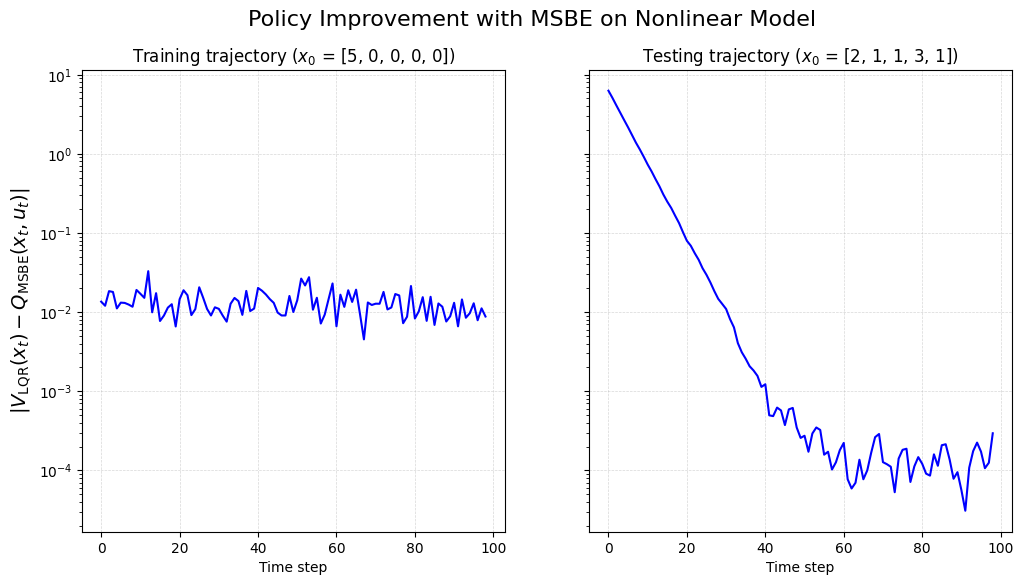

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']


ax1.semilogy(np.clip(np.abs(V_function_nonlin_PI["V_lqr_train"] - V_function_nonlin_PI["V_PI_train"]), 1e-18, None), color = 'blue')
ax2.semilogy(np.clip(np.abs(V_function_nonlin_PI["V_lqr_test"] -  V_function_nonlin_PI["V_PI_test"]), 1e-18, None), color = 'blue')

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1))

ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

ax2.set_title(rf"Testing trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

fig.suptitle("Policy Improvement with MSBE on Nonlinear Model", fontsize=16)
plt.show()